# NHL Game Prediction Project

### Step 1: Import libraries

In [48]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

### Step 2: Data Cleaning and Preparation

In [49]:
def load_data(file_stats):
    nhl_stats_df= pd.read_csv(file_stats)
    return nhl_stats_df

nhl_stats_df = load_data('../notebooks/generated/final_nhl_stats.csv')

In [50]:
nhl_stats_df.shape

(5248, 24)

Firstly, we should rename the columns to more trivial names and remove non-relevent columns

- Days Btwn Games => Rest_Days
- GP => Games_Played
- P => Points
- P% => Point%
- GF/GP => Goals_For
- GA/GP => Goals_Against
- GD/GP => Goals_Diff
- Shots/GP => Shots
- SA/GP => Shots_Against
- SD/GP => Shots_Diff
- PP Opp/GP => PP_Opportunities
- TS/GP => Times_Shorthanded

dropping columns: Points, Games_Played, T, Point%
<br>
Reason for dropping: These values provide no important information

In [51]:
nhl_stats_df.rename(columns={'Days Btwn Games' : 'Rest_Days', 
                            'GP' : 'Games_Played',
                            'P': 'Points',
                            'P%': 'Points%',
                            'GF/GP': 'Goals_For',
                            'GA/GP': 'Goals_Against',
                            'Shots/GP': 'Shots',
                            'SA/GP': 'Shots_Against',
                            'SD/GP': 'Shots_Diff',
                            'PP Opp/GP': 'PP_Opportunities',
                            'TS/GP': 'Time_Shorthanded'}, inplace=True)

In [52]:
nhl_stats_df.drop(columns=['Points', 'Games_Played', 'T', 'Points%'], inplace=True)

In [53]:
nhl_stats_df.head(1)

,Team,Opp Team,Game Date,Rest_Days,W,L,OT,Goals_For,Goals_Against,GD/GP,Shots,Shots_Against,Shots_Diff,PP_Opportunities,Time_Shorthanded,PP%,PK%,FOW%,Goalie,Sv%
0,Tampa Bay Lightning,PIT,2021-10-12,4,0,1,0,2,6,-4,28,35,-7,1,1,0,100,50.7,Andrei Vasilevskiy,0.906


# Step 3: Null
Lets deal with null or '--' values.
<br>
First lets check which columns have '--' values. Scrolling through the data, it should be the T (which we removed so we don't have to deal with this), PP%, and PK% columns.
<br>
We will check this next
<br><br>
**why?**
<br><br>For one thing, ties can't happen in hockey. _Again, this column was already removed_
<br><br>Secondly, a team can get no power play opportunities. Therefore, their pp% is '--' which technically isn't 0%. There isn't a percent. (fyi you will notice that the PP_oportunities column is 0 when pp% column is --)
<br><br>Finally, same logic applies to pk%. An opposing team can get no pp opportunities either so the home team's pk% can't exist

In [54]:
columns_with_dash = nhl_stats_df.columns[(nhl_stats_df == '--').any()].tolist()
columns_with_dash

['PP%', 'PK%']

**So how should we deal with this?**
We can DROP these rows onyl because they are rare. We will lose a little bit of data but won't cause a massive dent to the amount we would have left.
<br>
This also avoids needing special handling.
<br><br>
Lets check how many rows would be affected

In [55]:
count_nan_pp = nhl_stats_df['PP%'].value_counts().get('--', 0)
count_nan_pk = nhl_stats_df['PK%'].value_counts().get('--', 0)
print(f"PP% NaN count: {count_nan_pp}")
print(f"PK% NaN count: {count_nan_pk}")
print(f"Total NaN count: {count_nan_pp + count_nan_pk}")
print(f"PP% NaN percentage: {count_nan_pp / len(nhl_stats_df) * 100:.2f}%")
print(f"PK% NaN percentage: {count_nan_pk / len(nhl_stats_df) * 100:.2f}%")
print(f"Total NaN percentage: {(count_nan_pp + count_nan_pk) / len(nhl_stats_df) * 100:.2f}%")

PP% NaN count: 85
PK% NaN count: 122
Total NaN count: 207
PP% NaN percentage: 1.62%
PK% NaN percentage: 2.32%
Total NaN percentage: 3.94%


In [56]:
nhl_stats_df.shape

(5248, 20)

Almost 4% of the total rows will be dropped. It's more than I hoped so new solution coming soon ;)
<br>
total rows affected = 3.94% of 5248 = 0.0394 * 5244 = 206.7712

In [57]:
nhl_stats_df = nhl_stats_df[nhl_stats_df['PP%'] != '--']
nhl_stats_df = nhl_stats_df[nhl_stats_df['PK%'] != '--']
count_nan_pp = nhl_stats_df['PP%'].value_counts().get('--', 0)
count_nan_pk = nhl_stats_df['PK%'].value_counts().get('--', 0)
print(f"PP% NaN count after cleaning: {count_nan_pp}")
print(f"PK% NaN count after cleaning: {count_nan_pk}")

PP% NaN count after cleaning: 0
PK% NaN count after cleaning: 0


In [58]:
nhl_stats_df.shape

(5049, 20)

Lets do a life check:

In [59]:
nhl_stats_df.head()

,Team,Opp Team,Game Date,Rest_Days,W,L,OT,Goals_For,Goals_Against,GD/GP,Shots,Shots_Against,Shots_Diff,PP_Opportunities,Time_Shorthanded,PP%,PK%,FOW%,Goalie,Sv%
0,Tampa Bay Lightning,PIT,2021-10-12,4,0,1,0,2,6,-4,28,35,-7,1,1,0,100,50.7,Andrei Vasilevskiy,0.906
1,Vegas Golden Knights,SEA,2021-10-12,4,1,0,0,4,3,1,30,31,-1,3,3,0,100,52.0,Robin Lehner,0.903
2,Toronto Maple Leafs,MTL,2021-10-13,4,1,0,0,2,1,1,30,32,-2,3,4,33.3,100,58.2,Jack Campbell,0.969
3,Washington Capitals,NYR,2021-10-13,4,1,0,0,5,1,4,27,24,3,6,5,50,80,39.2,Vitek Vanecek,0.958
4,Colorado Avalanche,CHI,2021-10-13,4,1,0,0,4,2,2,36,34,2,4,3,0,66.7,43.6,Darcy Kuemper,0.941


### Step 3: History
A good feature is including the home team's matchup history agasint the oponent.
<br><br>
For example, if the Ottawa Senators have a +3 record (they won 3 games more this season) against Montreal Canadiens it could be a good indicator they will win the 4th.
<br><br>
Similarly, if Ottawa had a -2 record (they lost 2 more games than they won against Montreal this season), it could suggest that Montreal has the upper hand in the matchup and may be more likely to win again.

Firstly, lets create a 'Season' column so grouping by season would be a lot easier later

In [60]:
import pandas as pd
import numpy as np

# Ensure Game Date is datetime
nhl_stats_df['Game Date'] = pd.to_datetime(nhl_stats_df['Game Date'])

# Define season date ranges
season_2021_start = pd.to_datetime('2021-10-12')
season_2021_end = pd.to_datetime('2022-06-26')  # fixed year
season_2022_start = pd.to_datetime('2022-10-07')
season_2022_end = pd.to_datetime('2023-06-13')
season_2023_start = pd.to_datetime('2023-10-10')
season_2023_end = pd.to_datetime('2024-06-24')
season_2024_start = pd.to_datetime('2024-10-04')
season_2024_end = pd.to_datetime('2025-05-25')

# Assign Season
nhl_stats_df['Season'] = np.where((nhl_stats_df['Game Date'] >= season_2021_start) & (nhl_stats_df['Game Date'] <= season_2021_end), '2021-22',
                          np.where((nhl_stats_df['Game Date'] >= season_2022_start) & (nhl_stats_df['Game Date'] <= season_2022_end), '2022-23',
                          np.where((nhl_stats_df['Game Date'] >= season_2023_start) & (nhl_stats_df['Game Date'] <= season_2023_end), '2023-24',
                          np.where((nhl_stats_df['Game Date'] >= season_2024_start) & (nhl_stats_df['Game Date'] <= season_2024_end), '2024-25', 'Unknown'))))

# View results
print(nhl_stats_df['Season'].value_counts())
nhl_stats_df.head()


Season
2022-23    1281
2021-22    1262
2023-24    1258
2024-25    1248
Name: count, dtype: int64


,Team,Opp Team,Game Date,Rest_Days,W,L,OT,Goals_For,Goals_Against,GD/GP,...,Shots_Against,Shots_Diff,PP_Opportunities,Time_Shorthanded,PP%,PK%,FOW%,Goalie,Sv%,Season
0,Tampa Bay Lightning,PIT,2021-10-12,4,0,1,0,2,6,-4,...,35,-7,1,1,0,100,50.7,Andrei Vasilevskiy,0.906,2021-22
1,Vegas Golden Knights,SEA,2021-10-12,4,1,0,0,4,3,1,...,31,-1,3,3,0,100,52.0,Robin Lehner,0.903,2021-22
2,Toronto Maple Leafs,MTL,2021-10-13,4,1,0,0,2,1,1,...,32,-2,3,4,33.3,100,58.2,Jack Campbell,0.969,2021-22
3,Washington Capitals,NYR,2021-10-13,4,1,0,0,5,1,4,...,24,3,6,5,50,80,39.2,Vitek Vanecek,0.958,2021-22
4,Colorado Avalanche,CHI,2021-10-13,4,1,0,0,4,2,2,...,34,2,4,3,0,66.7,43.6,Darcy Kuemper,0.941,2021-22


In [61]:
# for each group, I want a history column that contains all the previous games played against that opposing team at home. What that means is that the first matchup, hsotry is 0. if they won the first game, the next history value is 1, if they loast the game after that, it subtracts 1 and th ehistory is back to 0. if they lost after that again, it's -1. that's just an example. Make this calculation for every gruop per season.
def calculate_history(group):
    history = []
    current_history = 0
    for index, row in group.iterrows():
        if index == 0:
            history.append(current_history)
        else:
            if row['W'] == 1 or row['OT'] == 1:
                current_history += 1
            elif row['L'] == 1:
                current_history -= 1
            history.append(current_history)
    group['History'] = history
    return group


Now we will group by the columns and apply the history function

In [69]:
#apply the calculate_history function to each group
nhl_stats_df = nhl_stats_df.groupby(['Season', 'Team', 'Opp Team'], group_keys=False).apply(calculate_history)
#reset the index
nhl_stats_df.reset_index(drop=True, inplace=True)
nhl_stats_df = nhl_stats_df.sort_values(by='Game Date').reset_index(drop=True)

C:\Users\riger\AppData\Local\Temp\ipykernel_7628\3523618227.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nhl_stats_df = nhl_stats_df.groupby(['Season', 'Team', 'Opp Team'], group_keys=False).apply(calculate_history)


### Step 4: Averages
We need to create new columns for the rolling averages of goals, goals against, shots, etc.
<br><br>
**caveat:**
<br>
The data is combined with 4 seasons. We know that we should find the average from start of season to curr date because this is the stat the NHL gives us for upcoming games. 
<br><br>
However, we can always calculate the **average of the last n games** for upcoming games too, and train this model with averages from the last n games. This will give more accruate stats on the team's recent performance but training this model around the data the NHL gives us (mostly) for upcoming games is simpler. There is room for a solution here though ;)
<br><br>
**When calculating the averges, should we include all previous season's performance?**
for example, should goals_for_averages in the 2023/2024 season include goals_for data from the 2021/2022 and 2022/2023 season too?
<br>
No, the NHL gives stats like team averages from the starts of the current season up to game date. not accross seasons. Inclusing past seasons data would mismatch what the model is trained on and what happens in the real world. In reality, every season is different because of various factors like: **age of players, coaching staff, other management, injuries, trades, having a 3+ month break, etc**
<br><br>
**Solution**
<br>Limit the sum calculation to the start of the current season to the current date<br>

In [ ]:
# Columns that need averaging
columns_to_average = ['Goals_For', 'Goals_Against', 'Shots', 'Shots_Against', 'Shots_Diff', 'PP_Opportunities', 'Time_Shorthanded', 'PP%', 'PK%']

In [10]:
# def rolling_averages(group, cols, new_cols):
#     rolling_stats = group[cols].shift(1).rolling(window=2, min_periods=1).mean()
#     group[new_cols] = rolling_stats
    
#     # rolling_stats = rolling_stats.fillna(group[cols])
#     # group = group.dropna(subset=new_cols)
#     # group[new_cols] = group[new_cols].fillna(0)
#     return group

def calculate_expanding_mean(group, cols, new_cols):
    # Calculate expanding mean excluding current game (excluding the current game)
    rolling_stats = group[cols].expanding(min_periods=1).mean().shift(1)  # Shift to exclude current game
    group[new_cols] = rolling_stats
    
    return group


In [11]:
def apply_team_rolling_avg(df):
    # Define the columns to calculate averages for
    stat_cols = ["gf/gp", "ga/gp", "shots for", "shots against", "pp opp/gp", "ts/gp", "pp%", "fow%"]
    avg_cols = [f"AVG_{c}" for c in stat_cols]

    # Group by team and calculate rolling averages
    df = df.groupby("team").apply(
        lambda x: calculate_expanding_mean(x, stat_cols, avg_cols)
        )

    return df.dropna(subset=avg_cols)


In [12]:
def apply_goalie_rolling_avg(df):
    # Define the columns to calculate averages for
    stat_cols = ["sv%"]
    avg_cols = ["AVG_sv%"]
    
    # Group by goalie and calculate rolling averages
    df = df.groupby("goalie").apply(
        lambda x: calculate_expanding_mean(x, stat_cols, avg_cols)
    )
    
    # Remove rows with NaN values (first appearance of each goalie)
    return df.dropna(subset=avg_cols)

In [13]:
def calculate_rolling_averages(df):
    """Calculate rolling averages for team and goalie statistics"""
    # Calculate team averages
    df = apply_team_rolling_avg(df)
    df = df.droplevel("team")
    
    # Calculate goalie averages
    df = apply_goalie_rolling_avg(df)
    
    # Sort and reset index
    df = df.sort_values(by="date")
    df.index = range(df.shape[0])
    
    return df

In [14]:
nhl_game_data_2024 = calculate_rolling_averages(nhl_game_data_2024)
nhl_game_data_2024.head(5)

C:\Users\riger\AppData\Local\Temp\ipykernel_16708\3372538226.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("team").apply(
C:\Users\riger\AppData\Local\Temp\ipykernel_16708\1837580578.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("goalie").apply(


,date,time,venue,rest days,result,gf/gp,ga/gp,net goals,opponent,shots for,...,home_win,AVG_gf/gp,AVG_ga/gp,AVG_shots for,AVG_shots against,AVG_pp opp/gp,AVG_ts/gp,AVG_pp%,AVG_fow%,AVG_sv%
0,2024-10-12,19:00,Home,1,L,5,2,3,Florida Panthers,27,...,1,1.0,3.333333,27.333333,27.666667,3.666667,3.666667,0.0,50.4,0.919
1,2024-10-12,13:00,Home,1,L,2,1,1,Los Angeles Kings,26,...,1,5.0,5.000000,28.500000,29.500000,4.500000,6.000000,22.5,49.2,0.833
2,2024-10-12,22:00,Home,1,W,0,2,-2,Anaheim Ducks,30,...,0,4.0,5.000000,29.000000,40.000000,2.000000,2.000000,50.0,41.7,1.000
3,2024-10-12,19:00,Away,1,L,5,3,2,Washington Capitals,33,...,0,3.0,2.000000,27.666667,23.666667,3.666667,2.666667,15.0,53.0,0.818
4,2024-10-12,19:00,Away,1,W,6,5,1,New York Rangers,26,...,0,5.0,3.000000,26.500000,26.500000,1.500000,4.500000,50.0,51.1,0.852


In [15]:
# def calculate_goalie_avg(group, cols, new_cols):
#     rolling_stats = group[cols].shift(1).rolling(window=2, min_periods=1).mean()
#     group[new_cols] = rolling_stats
    
#     # Optionally, handle missing values or drop NaNs if needed
#     group = group.dropna(subset=new_cols)
#     # group[new_cols] = group[new_cols].fillna(0)  # Optionally fill NaNs with 0

#     return group


In [16]:
# def apply_goalie_avg(df):
#     # Define columns for goalie stats and their corresponding average columns
#     stat_cols = ["sv%"]  # Column to calculate the rolling average for
#     avg_cols = ["AVG_sv%"]  # New column for rolling average

#     # Apply the rolling average for each goalie
#     df = df.groupby("goalie").apply(lambda x: calculate_goalie_avg(x, stat_cols, avg_cols))

#     # Optionally reset the index and sort the data
#     df = df.sort_values(by="date")
#     df.index = range(df.shape[0])

#     return df

# # Apply the function to the dataset
# nhl_game_data_2024 = apply_goalie_avg(nhl_game_data_2024)
# nhl_game_data_2024.head()

In [17]:
nhl_game_data_2024.shape

(1921, 34)

### Step 4: Creating game id's
* this will be useful later when combining the same home/away game into one row

In [18]:
def create_game_ids(df):
    # Ensure consistent sorting of 'team_pair'
    df['team_pair'] = df.apply(
        lambda row: tuple(sorted([row['team'], row['opponent']])), axis=1
    )

    # Combine 'date', 'time', and 'team_pair' to create a unique key
    df['game_key'] = (
    df['date'].astype(str) + '_' +
    df['time'].astype(str) + '_' +
    df['team_pair'].astype(str)
    )

    # Assign a unique numerical ID to each game
    df['game_id'] = pd.factorize(df['game_key'])[0] + 1

    df.drop(columns=['team_pair', 'game_key'], inplace=True)

    return df


#### Note: 
You will notice that in the begining of the season, there is one Home or Away game per game. This is because when calculating rolling averages, you can't find the average of the team's first game. Therefore, I dropped all rows with NaN "AVG" columns. This leaves the dataset to start with every team's second game

#### Note: 
Not only is the team's first game dropped. A goalie's first game is also dropped since I cannot calculate that goalie's average sv% with no prior games from that goalie

#### Issue: 
This cuts my dataset 

#### Solution (not yet implemented):
Focus on the TEAM'S average save%

In [19]:
nhl_game_data_2024 = create_game_ids(nhl_game_data_2024)
nhl_game_data_2024 = nhl_game_data_2024.sort_values('game_id')
nhl_game_data_2024.head()

,date,time,venue,rest days,result,gf/gp,ga/gp,net goals,opponent,shots for,...,AVG_gf/gp,AVG_ga/gp,AVG_shots for,AVG_shots against,AVG_pp opp/gp,AVG_ts/gp,AVG_pp%,AVG_fow%,AVG_sv%,game_id
0,2024-10-12,19:00,Home,1,L,5,2,3,Florida Panthers,27,...,1.0,3.333333,27.333333,27.666667,3.666667,3.666667,0.0,50.40,0.919,1
5,2024-10-12,19:00,Away,1,L,2,5,-3,Buffalo Sabres,25,...,3.5,3.500000,33.500000,29.500000,4.000000,3.500000,0.0,47.75,0.933,1
1,2024-10-12,13:00,Home,1,L,2,1,1,Los Angeles Kings,26,...,5.0,5.000000,28.500000,29.500000,4.500000,6.000000,22.5,49.20,0.833,2
2,2024-10-12,22:00,Home,1,W,0,2,-2,Anaheim Ducks,30,...,4.0,5.000000,29.000000,40.000000,2.000000,2.000000,50.0,41.70,1.000,3
3,2024-10-12,19:00,Away,1,L,5,3,2,Washington Capitals,33,...,3.0,2.000000,27.666667,23.666667,3.666667,2.666667,15.0,53.00,0.818,4


In [20]:
nhl_game_data_2024.shape

(1921, 35)

In [21]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


### Step 5: Combining Home and Away

In [22]:
# This is an example of a game with both Hoem and Away perspectives
# I will be combining these games, differenciated by 'home_' and 'away_' stats
nhl_game_data_2024.loc[nhl_game_data_2024['game_id'] == 25]

,date,time,venue,rest days,result,gf/gp,ga/gp,net goals,opponent,shots for,shots against,shot diff,pp opp/gp,ts/gp,pp%,pk%,fow%,team,goalie,sv%,opp_code,team_code,goalie_code,hour,home_win,AVG_gf/gp,AVG_ga/gp,AVG_shots for,AVG_shots against,AVG_pp opp/gp,AVG_ts/gp,AVG_pp%,AVG_fow%,AVG_sv%,game_id
31,2024-10-17,19:00,Home,1,L,6,4,2,Buffalo Sabres,25,24,1,3,2,33.3,100.0,49.1,Columbus Blue Jackets,Daniil Tarasov,0.833,2,7,20,19,1,3.666667,3.666667,31.333333,26.0,2.666667,3.333333,22.2,49.00,0.8670,25
43,2024-10-17,19:00,Away,0,W,4,6,-2,Columbus Blue Jackets,24,25,-1,2,3,0.0,66.7,50.9,Buffalo Sabres,Devon Levi,0.760,7,2,24,19,1,2.600000,3.600000,28.400000,30.2,3.000000,3.600000,0.0,48.14,0.9195,25


In [23]:
def combine_home_away_games(df):
    combined_rows = []

    # Group by a unique 'game_id'
    for _, group in df.groupby('game_id'):
        # Find home and away games
        home_games = group[group['venue'] == 'Home']
        away_games = group[group['venue'] == 'Away'] 

         # Only proceed if we have exactly one home and one away game (meaning nothing was dropped due to NA averages)
        if len(home_games) == 1 and len(away_games) == 1:
            # Get the home and away rows
            home_game = home_games.iloc[0]
            away_game = away_games.iloc[0]

            # Create a new row combining home and away features
            combined_row = {
                'game_id': home_game['game_id'],
                'date': home_game['date'],
                'time': home_game['time'],
                # 'venue_code': home_game['venue_code'],
                'opp_code': away_game['opp_code'],
                'team_code': away_game['team_code'],
                'home_team': home_game['team'],
                'away_team': away_game['team'],
                'home_goalie': home_game['goalie'],
                'away_goalie': away_game['goalie'],
                'home_goalie_code': home_game['goalie_code'],
                'away_goalie_code': away_game['goalie_code'],
                'hour': home_game['hour'],
                'rest_days_home': home_game['rest days'],
                'rest_days_away': away_game['rest days'],
                'home_AVG_gf/gp': home_game['AVG_gf/gp'],
                'home_AVG_ga/gp': home_game['AVG_ga/gp'],
                'home_AVG_shots for': home_game['AVG_shots for'],
                'home_AVG_shots against': home_game['AVG_shots against'],
                'home_AVG_pp opp/gp': home_game['AVG_pp opp/gp'],
                'home_AVG_ts/gp': home_game['AVG_ts/gp'],
                'home_AVG_pp%': home_game['AVG_pp%'],
                'home_AVG_fow%': home_game['AVG_fow%'],
                'home_AVG_sv%': home_game['AVG_sv%'],
                'away_AVG_gf/gp': away_game['AVG_gf/gp'],
                'away_AVG_ga/gp': away_game['AVG_ga/gp'],
                'away_AVG_shots for': away_game['AVG_shots for'],
                'away_AVG_shots against': away_game['AVG_shots against'],
                'away_AVG_pp opp/gp': away_game['AVG_pp opp/gp'],
                'away_AVG_ts/gp': away_game['AVG_ts/gp'],
                'away_AVG_pp%': away_game['AVG_pp%'],
                'away_AVG_fow%': away_game['AVG_fow%'],
                'away_AVG_sv%': away_game['AVG_sv%'],
                'home_win': home_game['home_win']  # home_win is based on the home team's outcome
            }

            # Add the combined row to the list
            combined_rows.append(combined_row)
        # else:
        #     if len(home_games) == 0:
        #         print("This game was removed from data because it didn't have HOME game data. Away game ID:", away_games.iloc[0]['game_id'])
        #     else:
        #         print("This game was removed from data because it didn't have AWAY game data. Away game ID:", home_games.iloc[0]['game_id'])
                
    # Create a new DataFrame with the combined rows
    combined_df = pd.DataFrame(combined_rows)
    return combined_df


In [24]:
combined_nhl_game_data_2024 = combine_home_away_games(nhl_game_data_2024)

#### Note:
As mentioned before, I am cutting out the rows that were missing averages, and their counterparts because you can't have a full row with out both Home and Away

#### Issue:
This cut my dataset in half. However, this is almost (except for the first couple games) the total number of games played this season by every team combined. 

#### Note to self:
Is this enough data or should the previous season be added in?

In [25]:
combined_nhl_game_data_2024.shape

(928, 33)

In [26]:
combined_nhl_game_data_2024.to_csv('../data/output_model_data.csv', index=False)  

### Step 6: Visualize feature correlations

In [27]:
def visualize_correlations(df, feature_cols):
    corr = df[feature_cols].corr()
    sns.heatmap(corr, annot=False, cmap="coolwarm")
    plt.show()

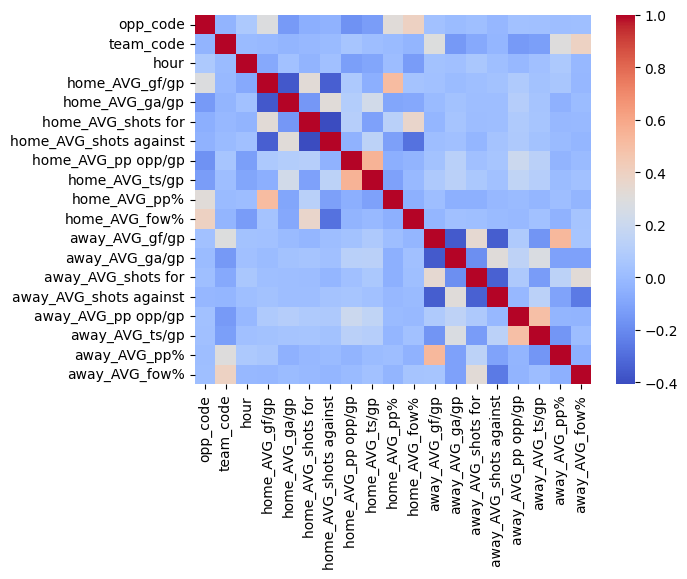

In [28]:
#cols = ['opp_code', 'team_code', 'hour', 'home_goalie_code', 'away_goalie_code', 'home_AVG_gf/gp', 'home_AVG_ga/gp', 'home_AVG_shots for', 'home_AVG_shots against', 'home_AVG_pp opp/gp', 'home_AVG_ts/gp', 'home_AVG_pp%', 'home_AVG_fow%', 'away_AVG_gf/gp', 'away_AVG_ga/gp', 'away_AVG_shots for', 'away_AVG_shots against', 'away_AVG_pp opp/gp', 'away_AVG_ts/gp', 'away_AVG_pp%', 'away_AVG_fow%']
cols = ['opp_code', 
        'team_code', 
        'hour', 
        'home_AVG_gf/gp',
        'home_AVG_ga/gp', 
        'home_AVG_shots for', 
        'home_AVG_shots against', 
        'home_AVG_pp opp/gp', 
        'home_AVG_ts/gp', 
        'home_AVG_pp%', 
        'home_AVG_fow%', 
        'away_AVG_gf/gp', 
        'away_AVG_ga/gp', 
        'away_AVG_shots for', 
        'away_AVG_shots against', 
        'away_AVG_pp opp/gp', 
        'away_AVG_ts/gp', 
        'away_AVG_pp%', 
        'away_AVG_fow%']

visualize_correlations(combined_nhl_game_data_2024, cols)

### Step 7: Preprocessing

In [29]:
#Feature cols MINUS GOALIE FEATURES FOR NOW

feature_cols = [
    'team_code', 
    'opp_code',
    'rest_days_home', 
    'rest_days_away', 
    'home_AVG_gf/gp',
    'away_AVG_gf/gp',
    'home_AVG_ga/gp',
    'away_AVG_ga/gp',
    'home_AVG_pp%',
    'away_AVG_pp%',
    'home_AVG_fow%',
    'away_AVG_fow%'
]

Splitting training/testing data

In [30]:
from sklearn.model_selection import train_test_split

# Define features and target
X = combined_nhl_game_data_2024[feature_cols]
y = combined_nhl_game_data_2024['home_win']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# # Ensure the 'date' column is in datetime format
# combined_nhl_game_data_2024['date'] = pd.to_datetime(combined_nhl_game_data_2024['date'])

# # Sort the data by date
# combined_nhl_game_data_2024 = combined_nhl_game_data_2024.sort_values(by='date')

# # Define a specific date to split the data
# train_end_date = '2025-01-28'  # The date up to which the training data should go

# # Split the data based on the date
# train_data = combined_nhl_game_data_2024[combined_nhl_game_data_2024['date'] <= train_end_date]
# test_data = combined_nhl_game_data_2024[combined_nhl_game_data_2024['date'] > train_end_date]

# # Separate features and target for both training and testing sets
# X_train = train_data[feature_cols]
# y_train = train_data['home_win']
# X_test = test_data[feature_cols]
# y_test = test_data['home_win']



### Step 7: Hyperparameter Tuning

In [31]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 20, None],
#     'min_samples_split': [5, 10, 20],
#     'min_samples_leaf': [2, 5, 10],
#     'max_features': ['sqrt', 'log2', None]
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=1, class_weight='balanced'),
#     param_grid,
#     cv=5,
#     scoring='accuracy'
# )

# grid_search.fit(X_train, y_train)
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Cross-validation Score: {grid_search.best_score_:.4f}")

### Step 8: Training The Model

In [32]:

params = {
    'max_depth': 5,
    'max_features': None,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 100
}

model = RandomForestClassifier(**params, random_state=1, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=None,
                       min_samples_leaf=2, min_samples_split=5, random_state=1)

### Step 9: Evaluation

In [33]:
# Evaluate the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5753

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.62      0.58        87
           1       0.62      0.54      0.57        99

    accuracy                           0.58       186
   macro avg       0.58      0.58      0.58       186
weighted avg       0.58      0.58      0.58       186



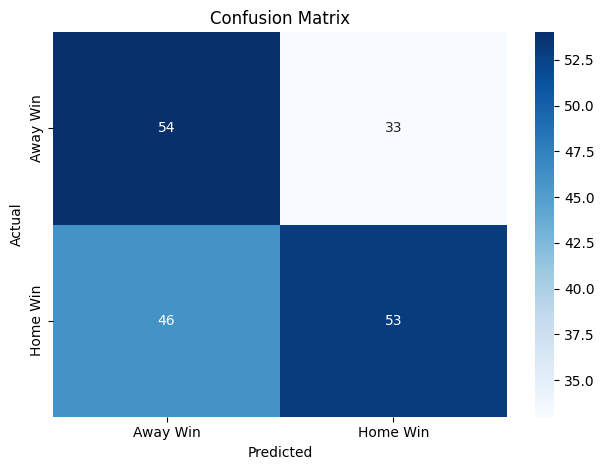

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Away Win', 'Home Win'],
            yticklabels=['Away Win', 'Home Win'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


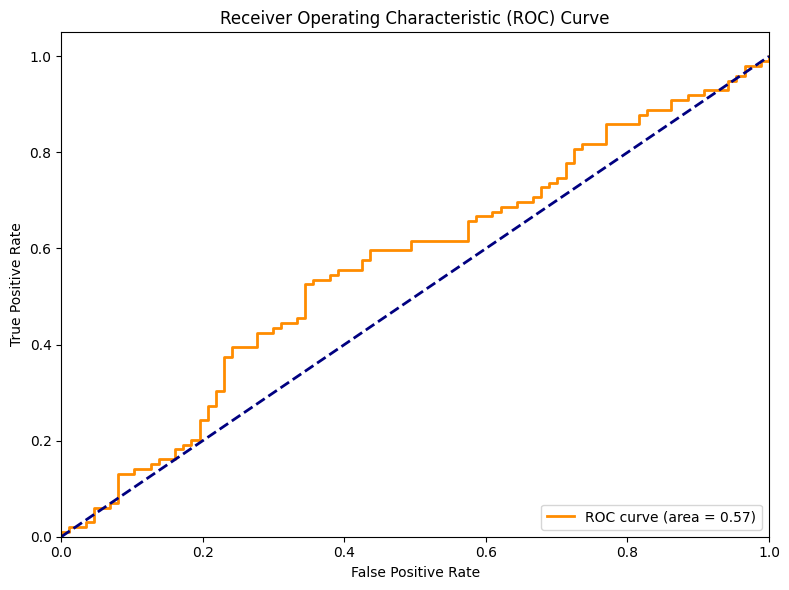

In [35]:
# ROC Curve (true positive and false positive rates)
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### Step 9: Find feature importances

           Feature  Importance
4   home_AVG_gf/gp    0.131019
9     away_AVG_pp%    0.129381
5   away_AVG_gf/gp    0.126040
10   home_AVG_fow%    0.103842
8     home_AVG_pp%    0.098660
7   away_AVG_ga/gp    0.090299
6   home_AVG_ga/gp    0.083670
11   away_AVG_fow%    0.076993
1         opp_code    0.059656
0        team_code    0.054990
3   rest_days_away    0.027769
2   rest_days_home    0.017681
Low importance features: []


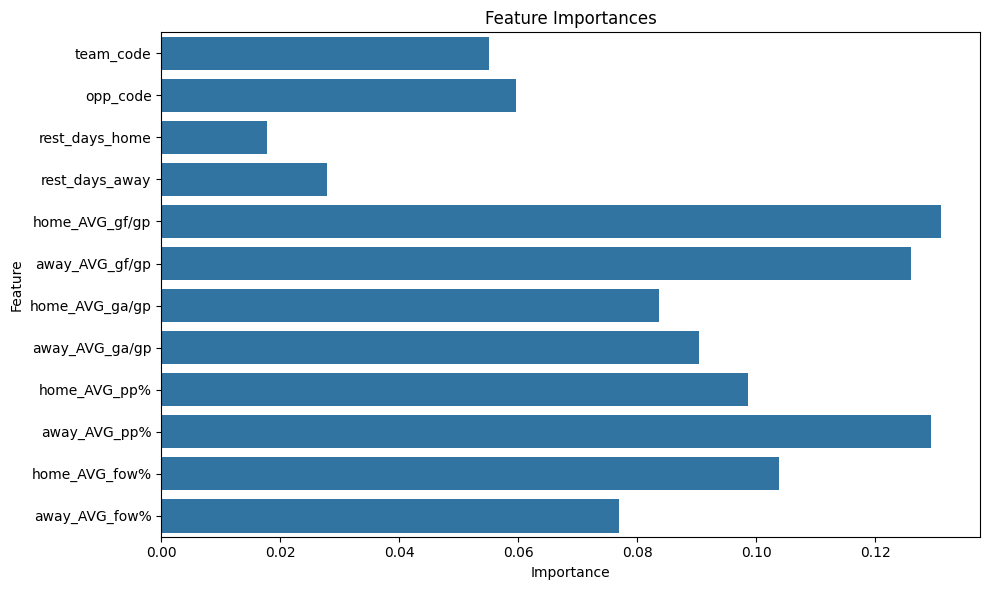

In [36]:
importances = model.feature_importances_

# Create a DataFrame to easily view and sort feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
sorted_features = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display sorted feature importances
print(sorted_features)

lower_importance_features = sorted_features[sorted_features['Importance'] < 0.01]
print(f"Low importance features: {lower_importance_features['Feature'].tolist()}")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

#### Show example prediction

In [37]:
# Include home_team and away_team names
test_results = X_test.copy()
test_results['home_team'] = combined_nhl_game_data_2024.loc[X_test.index, 'home_team']
test_results['away_team'] = combined_nhl_game_data_2024.loc[X_test.index, 'away_team']
test_results['date'] = combined_nhl_game_data_2024.loc[X_test.index, 'date']

# Add actual results
test_results['Actual'] = y_test.values

# Add predicted results
test_results['Predicted'] = y_pred

# Add probabilities of home win (if required)
test_results['Predicted_Prob'] = model.predict_proba(X_test)[:, 1]

# Display the first few rows of the results with team names
cols = ['date', 'home_team', 'away_team', 'Actual', 'Predicted', 'Predicted_Prob']
test_results[cols].loc[test_results['date'] == '2025-03-11']

,date,home_team,away_team,Actual,Predicted,Predicted_Prob
919,2025-03-11,Philadelphia Flyers,Ottawa Senators,0,0,0.465543
917,2025-03-11,New Jersey Devils,Columbus Blue Jackets,1,0,0.437141


### Export Model

In [38]:
# import pickle

# #save the model
# pickle.dump(model, open('../../backend/model.pkl', 'wb'))

#### Example Usage

In [39]:
def predict_game(my_model, game_data):
    for col in feature_cols:
        if col not in game_data.columns:
            raise ValueError(f"Missing required feature: {col}")
    
    # Make prediction
    prediction = my_model.predict(game_data[feature_cols])
    probability = my_model.predict_proba(game_data[feature_cols])[:, 1]
    
    return {
        'home_win_prediction': bool(prediction[0]),
        'home_win_probability': probability[0]
    }

In [40]:
#This is a test game happening on March 12th
# Result of game (real): Seattle (in overtime)

future_game = pd.DataFrame({
    'team_code': [23],  # Seattle
    'opp_code': [14],  # Montreal
    'rest_days_home': [2],
    'rest_days_away': [0],
    'home_AVG_gf/gp': [2.94],
    'away_AVG_gf/gp': [2.94],
    'home_AVG_ga/gp': [3.22],
    'away_AVG_ga/gp': [3.25],
    'home_AVG_pp%': [18],
    'away_AVG_pp%': [82],
    'home_AVG_fow%': [48.9],
    'away_AVG_fow%': [50.9]
})

prediction_result = predict_game(model, future_game)

if prediction_result['home_win_prediction']:
    print(f"Prediction: Seattle will win at home")
    print(f"Win probability: {prediction_result['home_win_probability']:.2%}")
else:
    print(f"Prediction: Montreal will win away")
    print(f"Win probability: {1 - prediction_result['home_win_probability']:.2%}")

Prediction: Montreal will win away
Win probability: 59.89%
